In [149]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal as sig
import pylab as py
from IPython.display import Audio

In [150]:
ls

BeatDetection.ipynb
BeatDetection_dohun.ipynb
ECE210_Python_Session4_students_new.ipynb
JingleBells.wav
README.md
bottle_60bpm.wav
bottle_90bpm.wav
willy.wav


In [9]:
# This function takes file name string and imports audio file in the same directory
# returns, sampling rate and the audio file. 
def importAudio(filename):
    return wav.read(filename)

def plotAudio(filename):
    [fs, x] = wav.read(filename)
    m = x.shape[0]
    t = np.linspace(0.0, m/fs, m)
    fig, axes = plt.subplots(1, 1)
    axes.plot(t, x,'r')
    plt.show()
#def plotFFTmag
#def plotFFTphase

In [13]:
def filterbank(signal, bandlimits, Fs):

    transform = fft.fft(signal)
    n = len(transform)   
    n_bands = len(bandlimits)
    bl = np.zeros((n_bands))
    br = np.zeros((n_bands))
    for i in range(n_bands-1):
        bl[i] = (np.floor(bandlimits[i]/Fs*n/2)+1)
        br[i] = (np.floor(bandlimits[i+1]/Fs*n/2))
    bl = bl.astype(int)
    br = br.astype(int)
    bl[n_bands-1] = np.floor(bandlimits[n_bands-1]/Fs*n/2)+1
    br[n_bands-1] = np.floor(n/2)
    print(bl, br, bandlimits[n_bands-1]/Fs*n/2+1, n/2)
 
    output = np.zeros((n,n_bands))

    for i in range(n_bands):
        output[bl[i]:br[i],i] = transform[bl[i]:br[i]]
        output[n+1-br[i]:n+1-bl[i],i] = transform[n+1-br[i]:n+1-bl[i]]
        
    output[0,0]=0;    
    return output  

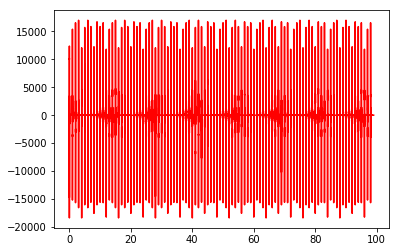

In [14]:
plotAudio('bottle_60bpm.wav')

In [25]:
def hwindow(signal, winlength, bandlimits, Fs):
    
    n = len(signal)
    n_bands = len(bandlimits)
    han_len = (winlength*2*Fs)//1
    
    hann = np.zeros((n))
    
    for a in range(han_len):
        hann[a] = np.square((np.cos(a*np.pi/han_len/2)))  
    wave = np.zeros((n, n_bands))
    for i in range(n_bands):
        wave[:,i] = np.real(fft.ifft(signal[:,i]))
        
    for i in range(n_bands):
        for j in range(n):
            if wave[j,i] < 0:
                wave[j,i] = -wave[j,i]
        wave[:,i] = fft.fft(wave[:,i]);
        
    for i in range(n_bands):
        wave[:,i] = np.multiply(wave[:,i],fft.fft(hann))
        wave[:,i] = np.real(fft.ifft(wave[:,i]))
    return wave

In [17]:
'''
def hwindow(signal, winlength, bandlimits, Fs):
    
    n = len(signal)
    n_bands = len(bandlimits)
    han_len = (winlength*2*Fs)//1
    
    hann = np.hanning(han_len) 
        
    wave = np.real(fft.ifft(signal))
    wave = np.abs(wave)
    wave = fft.fft(wave)
    hann = np.stack((hann,hann,hann,hann,hann,hann), axis=1)
    wave = np.multiply(wave,fft.fft(hann,n))
    
    return np.real(fft.ifft(wave))
    '''

'\ndef hwindow(signal, winlength, bandlimits, Fs):\n    \n    n = len(signal)\n    n_bands = len(bandlimits)\n    han_len = (winlength*2*Fs)//1\n    \n    hann = np.hanning(han_len) \n        \n    wave = np.real(fft.ifft(signal))\n    wave = np.abs(wave)\n    wave = fft.fft(wave)\n    hann = np.stack((hann,hann,hann,hann,hann,hann), axis=1)\n    wave = np.multiply(wave,fft.fft(hann,n))\n    \n    return np.real(fft.ifft(wave))\n    '

In [18]:
# Input: audio is a 2D np.array, with each column being a frequency band
def diffrect(audio):
    audio = np.diff(audio, axis=0)
    audio[audio < 0] = 0
    return audio

def combfilter(audio, accuracy, minBPM, maxBPM, bandlimits, maxfreq):
    length = audio.shape[0]
    bands = bandlimits.shape[0]
    dft = np.zeros((length, bands))
    for i in range(bands):
        print('ffting')
        dft[:,i] = fft.fft(audio[:,i])
    maxEnergy = 0
    percent = 0
    npulse = 3
    for bpm in range(minBPM, maxBPM) :#modify loop to modify accuracy
        # progress
        percent = 100*(bpm-minBPM)/(maxBPM-minBPM)
        # try comb with given bpm
        energy = 0
        comb = np.zeros(length)
        period = np.floor(60/bpm*2*maxfreq)
        for i in range(npulse) :
            comb[i*(period.astype(int))] = 1
        dftcomb = fft.fft(comb)
        dftcomb = np.stack((dftcomb, dftcomb,dftcomb,dftcomb,dftcomb,dftcomb), axis=1)
        energy = np.sum(np.abs(dft*dftcomb)**2)
        if (energy > maxEnergy):
            currBPM = bpm
            maxEnergy = energy
    return currBPM



In [26]:
[fs, audio] = importAudio('bottle_60bpm.wav')
bandlimits = np.array([0, 200, 400, 800, 1600, 3200])

signal = filterbank(audio, bandlimits, fs)
audio = hwindow(signal, 1, bandlimits, fs)
audio = diffrect(audio)
print(combfilter(audio, 1, 34, 74, bandlimits, fs))

[     1   9903  19805  39610  79220 158439] [   9902   19804   39609   79219  158438 2376576] 158439.4 2376576.0


/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


ffting


/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


ffting
ffting
ffting
ffting
ffting
60


In [152]:
[fs, audio] = importAudio('willy.wav')

/Users/Nicola/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [153]:
def energy_beat(audio , Fs):
    avg_e = 0.0
    inst_e = 0.0
    n = len(audio)
    beats = np.zeros(n//1000);
    b = n//48000
    for i in range(1,b):
        avg_e = 0
        for j in range(48000):
            avg_e = avg_e + audio[j+(i*48000)]*audio[j+(i*48000)]
        avg_e = avg_e/48000
        for x in range(1,48):
            inst_e = 0
            for y in range(1000):
                inst_e = inst_e + audio[y+(x*1000)+(i*48000)]*audio[y+(x*1000)+(i*48000)]
            inst_e = inst_e/1000
            if(inst_e > avg_e):
                beats[x+(i*48)] = np.int(1)
    return beats

In [155]:
beat = energy_beat(audio[:,0], fs)

/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in short_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/Nicola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in short_scalars
  from ipykernel import kernelapp as app


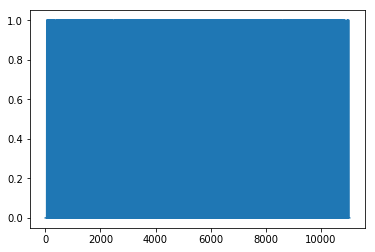

In [156]:
plt.plot(beat)

In [157]:
beat_diff = np.diff(beat)


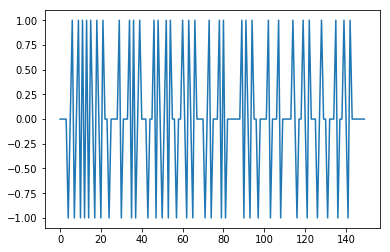

In [159]:
plt.plot(beat_diff[50:200])

In [160]:
Audio(np.abs(beat_diff)*10000, rate = fs/100)